# Bayesian melding of epidemiological models on Italian COVID-19 cases

Since the method is extremely slow, only disjoint windows of "daywindows" days are evaluated on three models (SIR, SIRD and hidden SEIRD).

Numerical instability is a critical issue and joint probabilities are defined in order to avoid them as much as possible (especially variances in priors and likelihoods are chosen empirically).

In [1]:
!pip install sympy==1.7.1
import numpy as np
import math
from matplotlib import pyplot as plt
import pandas as pd
from sympy import Symbol, stats

import models
import melding



def rmse(true, pred):
    out = 0
    for i in range(len(true)):
        out += (true[i] - pred[i]) ** 2
    return (out / len(true)) ** 0.5

## Sample importance-resampling algorithm in a univariate case

In order to exemplify the general algorithm, melding is tested on a toy example.
An uninformative prior (uniform pdf) is used to "guess" the values of a gaussian.
Since there is no model, the "pooling" is done with 100% of the observed data and 0% of the model predictions.

Having discrete observations of a single variable, sampling can be done using numpy only.

3.039999999999999
0.9983999999999998


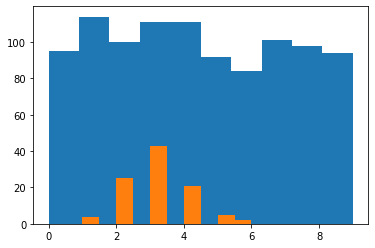

In [2]:
# Sample:
input = np.array([i for i in range(10)])
priors = np.array([1 / 10 for _ in range(10)])

samples = np.zeros(1000, dtype=float)

for i in range(samples.shape[0]):
  samples[i] = np.random.choice(input, p=priors)

plt.hist(samples)

# Importance computation:
weights = np.array([(1 / math.sqrt(2 * math.pi)) * math.e ** (-(x - 3)**2 / 2) for x in samples]) # Instead of pooling, for simplicity we're using the actual observed density.
weights /= np.sum(weights)


# Resampling:
resamples = np.zeros(100, dtype=float)
for i in range(resamples.shape[0]):
  resamples[i] = np.random.choice(samples, p=weights)

plt.hist(resamples)

# Mean and variance of the new samples:
mean = 0
std = 0
for r in resamples:
  mean += r / resamples.shape[0]

for r in resamples:
  std += (r - mean) ** 2 / resamples.shape[0]

print(mean) # Correctly predicts a value close to 3
print(std) # Correctly predicts a value close to 1



## SEIRD predicted by a SIR Toy example

Unlike the first example, in this case (and the following) probabilities are continuous and the pdfs are multivariate.

We assume that each parameter is independent of each other and that it can follow either a normal density (if we know mean and variance) or a uniform density (if we don't know anything).

Although we will know the values for each compartment in practice, for this example, they are treated as variables, also to see how much an increase in number of dimensions in the search space can affect accuracy and the number of samples required.

Our observed data are produced by a SEIRD model with t=100, S=100, E=1, I=0, R=0, D=0, beta=0.1, gamma=0.01, sigma=1, f=0.5, c=0.02, but we are trying to fit them with a simpler SIR model.

We assume a good prior knowledge of S0, I0 and R0 (mean around the correct value and small variance) and complete ignorance about beta, gamma (lower bound of 0 and upper bound of 1) and the outputs (uniform within "reasonable" boundaries).

{'S': 6.590651001083518e-18, 'E': 7.153824412261555e-19, 'I': 0.020373560275763373, 'R': 0.00043348000586730586, 'D': 100.97919295971835}


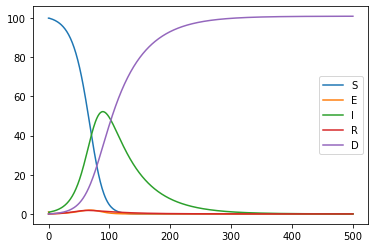

In [3]:
my_seird = models.SEIRD(100, 1, 0, 0, 0, 0.1, 0.01, 1, 0.5, 0.02)
out = my_seird.eval_series(500)

for k, v in out.items():
    plt.plot(range(501), v, label=k)
plt.legend()

    
print(my_seird.eval_last(500))

In [5]:
s = Symbol("s", negative=False)
i = Symbol("i", negative=False)
r = Symbol("r", negative=False)
beta = Symbol("beta", negative=False)
gamma = Symbol("gamma", negative=False)

# Input priors and likelihoods:
S_p = stats.Normal(s, 100, 5)
I_p = stats.Normal(i, 1, 3)
R_p = stats.Normal(r, 0, 10)
Beta_p = stats.Uniform(beta, 0, 1)
Gamma_p = stats.Uniform(gamma, 0, 1)

# Output priors:
S_out_p = stats.Uniform(s, 0, 100)
I_out_p = stats.Uniform(i, 0, 100)
R_out_p = stats.Uniform(r, 0, 100)

#True observations:
true_model = models.SIR(100, 1, 0, 0.05, 0.02)
S_o, I_o, R_o = true_model.eval_last(100).values()


S_out_l = stats.Normal(s, S_o, 3)
I_out_l = stats.Normal(i, I_o, 3)
R_out_l = stats.Normal(r, R_o, 3)

input_prior = melding.Joint_pdf({"S0": S_p, "I0": I_p, "R0": R_p, "beta": Beta_p, "gamma": Gamma_p})
input_likelihood = melding.Joint_pdf({"S0": S_p, "I0": I_p, "R0": R_p, "beta": Beta_p, "gamma": Gamma_p})
output_prior = melding.Joint_pdf({"S": S_out_p, "I": I_out_p, "R": R_out_p})
output_likelihood = melding.Joint_pdf({"S": S_out_l, "I": I_out_l, "R": R_out_l})

In [6]:
model = models.SIR()
model_args = {"t": 100}


samples, means, variances = melding.melding(model, model_args, input_prior, output_prior, input_likelihood, output_likelihood, 10000, 1000)

print(means)
print(variances)

C:\ProgramData\Anaconda3\lib\site-packages\sympy\stats\rv.py:1104: UserWarning: 
The return type of sample has been changed to return an iterator
object since version 1.7. For more information see
https://github.com/sympy/sympy/issues/19061
  warnings.warn(filldedent(message))


{'S0': 102.01749077945958, 'I0': 1.2390260767019186, 'R0': 6.80147963464977, 'beta': 0.045568996505247455, 'gamma': 0.012214533148559314}
{'S0': 0.3287895027796604, 'I0': 0.06415303768956421, 'R0': 14.184033524637831, 'beta': 0.0026227999240972114, 'gamma': 0.0031506958518323896}


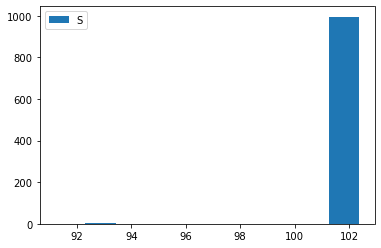

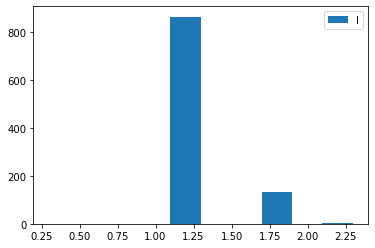

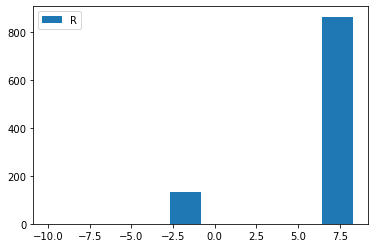

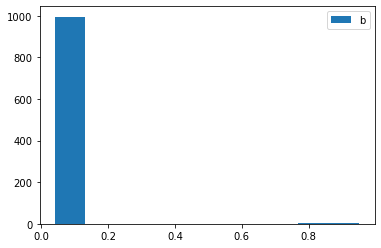

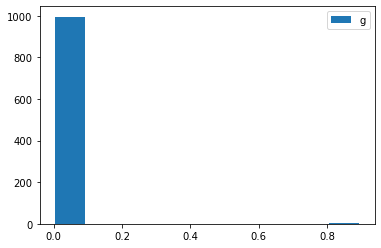

In [7]:
for k, _ in samples[0].items():
    tmp = [s[k] for s in samples]
    plt.hist(tmp)
    plt.legend(k)
    plt.show()

## Melding on real data

For the three models (SIR, SIRD and hidden SEIRD), the values fitted deterministically were used as "seed" for melding (ie. prior probabilities are Gaussians with mean set to the seed). In all cases, variances are empirically set to reduce numerical issues when computing joint probabilities.

### SIR

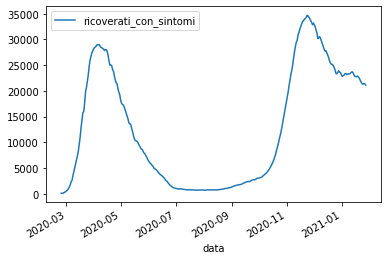

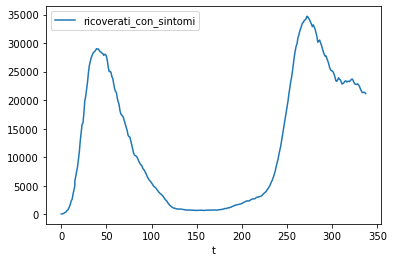

In [8]:

df = pd.read_csv("dpc-covid19-ita-andamento-nazionale.csv", parse_dates=["data"])
df.plot.line("data", "ricoverati_con_sintomi")

df["t"] = (df["data"] - df["data"].loc[0]) // np.timedelta64(1, "D")

df.plot.line("t", "ricoverati_con_sintomi")

     i   r         s
t                   
0  221   8  59999771
1  311  11  59999678
2  385  15  59999600
3  588  62  59999350
4  821  67  59999112
   Unnamed: 0            S0             I0            R0      beta     gamma  \
t                                                                              
0           0  5.999968e+07     372.830649      0.002978  0.285683  0.041429   
1           1  5.998769e+07   11522.535329   1128.915424  0.160836  0.039765   
2           2  5.991986e+07   62954.865038  17241.870378  0.058125  0.025255   
3           3  5.985406e+07   99658.960322  46283.325484  0.031279  0.024132   
4           4  5.980602e+07  109272.672125  84717.062751  0.017161  0.029408   

                 data  
t                      
0 2020-02-24 18:00:00  
1 2020-03-10 18:00:00  
2 2020-03-25 17:00:00  
3 2020-04-09 17:00:00  
4 2020-04-24 17:00:00  


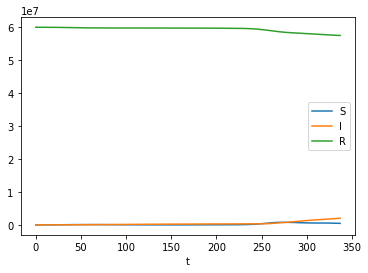

In [12]:
dataset = pd.DataFrame()
dataset["t"] = df["t"]
dataset["i"] = df["totale_positivi"]
dataset["r"] = df["dimessi_guariti"] + df["deceduti"]
dataset["s"] = 60000000 - (dataset["i"] + dataset["r"])

dataset = dataset.set_index("t")

dataset.plot.line()
plt.legend(["S", "I", "R"])
print(dataset.head())

sir_df = pd.read_csv("sir_params_weekly.csv", parse_dates=["data"])
sir_df = sir_df.set_index("t")

print(sir_df.head())

In [10]:
model = models.SIR()
daywindow =15

model_args = {"t": daywindow}

means = {}
variances = {}


s = Symbol("s", negative=False)
i = Symbol("i", negative=False)
r = Symbol("r", negative=False)
beta = Symbol("beta", negative=False)
gamma = Symbol("gamma", negative=False)

for d in range(0, len(dataset) // daywindow):
    print("Melding window {}-{}...".format(d * daywindow, (d + 1) * daywindow))
    window_df = dataset[d * daywindow: (d + 1) * daywindow].reset_index()
    # Input priors and likelihoods:
        # Input priors and likelihoods:
    S_p = stats.Normal(s, window_df["s"].loc[0], window_df["s"].std())
    I_p = stats.Normal(i, window_df["i"].loc[0], window_df["i"].std())
    R_p = stats.Normal(r, window_df["r"].loc[0], window_df["r"].std())
    
#     S_l = stats.Normal(s, window_df["s"].loc[0], 1)
#     I_l = stats.Normal(i, window_df["i"].loc[0], 1)
#     R_l = stats.Normal(r, window_df["r"].loc[0], 1)

    Beta_p = stats.Normal(beta, sir_df["beta"].loc[d // daywindow], 0.3)
    Gamma_p = stats.Normal(gamma, sir_df["gamma"].loc[d // daywindow], 0.3)
    Beta_l = stats.Uniform(beta, 0, 1)
    Gamma_l = stats.Uniform(gamma, 0, 1)

    # Output priors:
    S_out_p = stats.Normal(s, window_df["s"].mean(), window_df["s"].std())
    I_out_p = stats.Normal(i, window_df["i"].mean(), window_df["i"].std())
    R_out_p = stats.Normal(r, window_df["r"].mean(), window_df["r"].std())

    #True observations:
    S_out_l = stats.Normal(s, window_df["s"].loc[len(window_df) - 1], window_df["s"].std())
    I_out_l = stats.Normal(i, window_df["i"].loc[len(window_df) - 1], window_df["i"].std())
    R_out_l = stats.Normal(r, window_df["r"].loc[len(window_df) - 1], window_df["r"].std())
    
    input_prior = melding.Joint_pdf({"S0": S_p, "I0": I_p, "R0": R_p, "beta": Beta_p, "gamma": Gamma_p})
    input_likelihood = melding.Joint_pdf({"S0": S_p, "I0": I_p, "R0": R_p, "beta": Beta_l, "gamma": Gamma_l})
    output_prior = melding.Joint_pdf({"S": S_out_p, "I": I_out_p, "R": R_out_p})
    output_likelihood = melding.Joint_pdf({"S": S_out_l, "I": I_out_l, "R": R_out_l})
    
    _, tmp_mean, tmp_var = melding.melding(model, model_args, input_prior, output_prior, input_likelihood, output_likelihood, 10000, 500)
    for k, v in tmp_mean.items():
        if k not in means:
            means[k] = []
        means[k].append(v)
    for k, v in tmp_var.items():
        if k not in variances:
            variances[k] = []
        variances[k].append(v)

print(means)
print(variances)

Melding window 0-15...


C:\ProgramData\Anaconda3\lib\site-packages\sympy\stats\rv.py:1104: UserWarning: 
The return type of sample has been changed to return an iterator
object since version 1.7. For more information see
https://github.com/sympy/sympy/issues/19061
  warnings.warn(filldedent(message))


Melding window 15-30...
Melding window 30-45...
Melding window 45-60...
Melding window 60-75...
Melding window 75-90...
Melding window 90-105...
Melding window 105-120...
Melding window 120-135...
Melding window 135-150...
Melding window 150-165...
Melding window 165-180...
Melding window 180-195...
Melding window 195-210...
Melding window 210-225...
Melding window 225-240...
Melding window 240-255...
Melding window 255-270...
Melding window 270-285...
Melding window 285-300...
Melding window 300-315...
Melding window 315-330...
{'S0': [59998023.91819317, 59987431.193599984, 59932938.465707906, 59860762.32984551, 59805862.52860841, 59779018.05033671, 59769790.94018183, 59764183.06477498, 59761144.512337714, 59759706.54882167, 59754901.94484971, 59750189.03397048, 59747209.78467767, 59722687.871382885, 59701999.84107241, 59677215.7072294, 59556556.61329957, 59227705.41776771, 58699205.98993993, 58226595.22622531, 57990654.94857292, 57846375.73346797], 'I0': [882.329217749233, 8734.30035

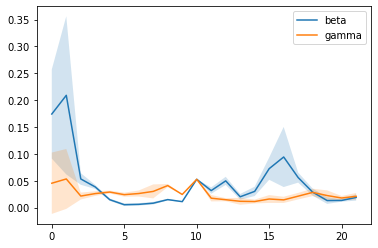

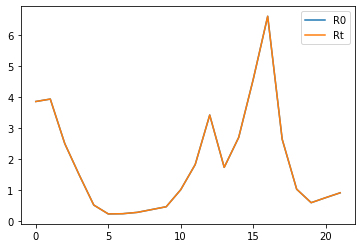

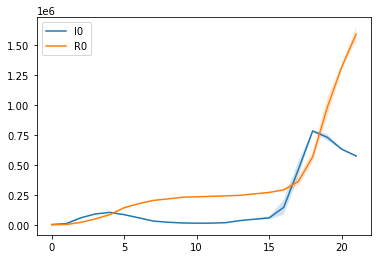

In [11]:
beta_err = np.array(variances["beta"]) ** 0.5
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.fill_between(range(0, len(means["beta"])), means["beta"] - beta_err, means["beta"] + beta_err, alpha=0.2)

gamma_err = np.array(variances["gamma"]) ** 0.5
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.fill_between(range(0, len(means["gamma"])), means["gamma"] - gamma_err, means["gamma"] + gamma_err, alpha=0.2)

plt.legend(["beta", "gamma"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.show()

# beta_err = np.array(variances["S0"]) ** 0.5
# plt.plot(range(0, len(means["S0"])), means["S0"])
# plt.fill_between(range(0, len(means["S0"])), means["S0"] - beta_err, means["S0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["I0"]) ** 0.5
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.fill_between(range(0, len(means["I0"])), means["I0"] - beta_err, means["I0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["R0"]) ** 0.5
plt.plot(range(0, len(means["R0"])), means["R0"])
plt.fill_between(range(0, len(means["R0"])), means["R0"] - beta_err, means["R0"] + beta_err, alpha=0.2)


plt.legend(["I0", "R0"]) # (["S0", "I0", "R0"])

plt.show()

In [12]:
sir_meld = pd.DataFrame(means)
sir_meld = sir_meld.reset_index()
sir_meld = sir_meld.rename(columns={"index":"t"})
dates = (sir_meld["t"] * daywindow).to_list()
sir_meld["data"] = df["data"][dates].to_list()


print(sir_meld.head())

sir_meld.to_csv("sir_melding_weekly.csv")

sir_meld = pd.DataFrame(variances)
sir_meld = sir_meld.reset_index()
sir_meld = sir_meld.rename(columns={"index":"t"})
dates = (sir_meld["t"] * daywindow).to_list()
sir_meld["data"] = df["data"][dates].to_list()


print(sir_meld.head())

sir_meld.to_csv("sir_melding_weekly_variances.csv")

   t            S0             I0            R0      beta     gamma  \
0  0  5.999802e+07     882.329218     19.606739  0.174159  0.045285   
1  1  5.998743e+07    8734.300360   1413.427801  0.208988  0.053249   
2  2  5.993294e+07   57414.291362  19122.307506  0.053243  0.021401   
3  3  5.986076e+07   89588.449077  48129.063612  0.038340  0.026006   
4  4  5.980586e+07  102783.373107  84041.461540  0.014615  0.028847   

                 data  
0 2020-02-24 18:00:00  
1 2020-03-10 18:00:00  
2 2020-03-25 17:00:00  
3 2020-04-09 17:00:00  
4 2020-04-24 17:00:00  
   t            S0            I0            R0      beta     gamma  \
0  0  3.027371e+06  9.247560e+05  4.709409e+04  0.006888  0.003266   
1  1  1.403287e+08  5.347730e+07  1.169151e+07  0.021691  0.003112   
2  2  2.373595e+08  3.462266e+07  1.430192e+07  0.000118  0.000042   
3  3  1.155188e+07  2.795400e+06  2.295394e+07  0.000014  0.000018   
4  4  5.976556e+07  1.324029e+05  4.985925e+07  0.000005  0.000007   

        

In [13]:
predictions = {}
in_keys = model.get_input_keys()
out_keys = model.get_output_keys()

for i in range(len(dataset) // daywindow):
    for k in range(len(in_keys)):
        model.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = model.eval_series(daywindow - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

RMS on S0: 31939.179536788626
RMS on I0: 15425.979537803967
RMS on R0: 25465.19636375021
Total RMSE: 72830.3554383428


### SIRD

In spite of the deterministic seeding and a large number of samples (50000), parameters are not estimated correctly.
This can be either a convergence (more samples are needed), numerical (seeds actually make harder to pool probabilities) or caused by the wrong probabilities (eg. variances too small/large).

In [14]:
dataset = pd.DataFrame()
dataset["t"] = df["t"]
dataset["i"] = df["totale_positivi"]
dataset["r"] = df["dimessi_guariti"]
dataset["d"] = df["deceduti"]
dataset["s"] = 60000000 - (dataset["i"] + dataset["r"])

dataset = dataset.set_index("t")

print(dataset.head())


sird_df = pd.read_csv("sird_params_weekly.csv", parse_dates=["data"])
sird_df = sird_df.set_index("t")

print(sird_df.head())

     i   r   d         s
t                       
0  221   1   7  59999778
1  311   1  10  59999688
2  385   3  12  59999612
3  588  45  17  59999367
4  821  46  21  59999133
   Unnamed: 0            S0             I0            R0            D0  \
t                                                                        
0           0  5.999968e+07     373.798452  3.418890e-09      0.000244   
1           1  5.998779e+07   11564.962649  6.095710e+02    371.286908   
2           2  5.991993e+07   62989.549526  9.153772e+03   7987.352997   
3           3  5.985407e+07   99669.589878  2.782461e+04  18442.275649   
4           4  5.980600e+07  109265.750763  5.865432e+04  26086.275269   

       beta     gamma         f                data  
t                                                    
0  0.285997  0.027468  0.014603 2020-02-24 18:00:00  
1  0.161335  0.022312  0.018436 2020-03-10 18:00:00  
2  0.058229  0.015757  0.009690 2020-03-25 17:00:00  
3  0.031275  0.019128  0.005026 2020

In [15]:
model = models.SIRD()
model_args = {"t": daywindow}

means = {}
variances = {}


s = Symbol("s", negative=False)
i = Symbol("i", negative=False)
r = Symbol("r", negative=False)
d_sym = Symbol("d", negative=False)
beta = Symbol("beta", negative=False)
gamma = Symbol("gamma", negative=False)
f = Symbol("f", negative=False)

for d in range(0, len(dataset) // daywindow):
    print("Melding window {}-{}...".format(d * daywindow, (d + 1) * daywindow))
    window_df = dataset[d * daywindow: (d + 1) * daywindow].reset_index()
    # Input priors and likelihoods:
    S_p = stats.Normal(s, window_df["s"].loc[0], window_df["s"].std())
    I_p = stats.Normal(i, window_df["i"].loc[0], window_df["i"].std())
    R_p = stats.Normal(r, window_df["r"].loc[0], window_df["r"].std())
    D_p = stats.Normal(d_sym, window_df["d"].loc[0], window_df["d"].std())
    
#     S_l = stats.Normal(s, window_df["s"].loc[0], 1)
#     I_l = stats.Normal(i, window_df["i"].loc[0], 1)
#     R_l = stats.Normal(r, window_df["r"].loc[0], 1)

    Beta_p = stats.Normal(beta, sird_df["beta"].loc[d // daywindow], 0.1)
    Gamma_p = stats.Normal(gamma, sird_df["gamma"].loc[d // daywindow], 0.1)
    F_p = stats.Normal(f, sird_df["f"].loc[d // daywindow], 0.1)
#     Beta_p = stats.Uniform(beta, 0, 1)
#     Gamma_p = stats.Uniform(gamma, 0, 1)
#     F_p = stats.Uniform(f, 0, 1)
    Beta_l = stats.Uniform(beta, 0, 1)
    Gamma_l = stats.Uniform(gamma, 0, 1)
    F_l = stats.Uniform(f, 0, 1)

    # Output priors:
    S_out_p = stats.Normal(s, window_df["s"].mean(), window_df["s"].std())
    I_out_p = stats.Normal(i, window_df["i"].mean(), window_df["i"].std())
    R_out_p = stats.Normal(r, window_df["r"].mean(), window_df["r"].std())
    D_out_p = stats.Normal(d_sym, window_df["d"].mean(), window_df["d"].std())

    #True observations:
    S_out_l = stats.Normal(s, window_df["s"].loc[len(window_df) - 1], window_df["s"].std())
    I_out_l = stats.Normal(i, window_df["i"].loc[len(window_df) - 1], window_df["i"].std())
    R_out_l = stats.Normal(r, window_df["r"].loc[len(window_df) - 1], window_df["r"].std())
    D_out_l = stats.Normal(d_sym, window_df["d"].loc[len(window_df) - 1], window_df["d"].std())
    
    input_prior = melding.Joint_pdf({"S0": S_p, "I0": I_p, "R0": R_p, "D0": D_p, "beta": Beta_p, "gamma": Gamma_p, "f": F_p})
    input_likelihood = melding.Joint_pdf({"S0": S_p, "I0": I_p, "R0": R_p, "D0": D_p, "beta": Beta_l, "gamma": Gamma_l, "f": F_l})
    output_prior = melding.Joint_pdf({"S": S_out_p, "I": I_out_p, "R": R_out_p, "D": D_out_p})
    output_likelihood = melding.Joint_pdf({"S": S_out_l, "I": I_out_l, "R": R_out_l, "D": D_out_l})
    
    _, tmp_mean, tmp_var = melding.melding(model, model_args, input_prior, output_prior, input_likelihood, output_likelihood, 50000, 2000)
    for k, v in tmp_mean.items():
        if k not in means:
            means[k] = []
        means[k].append(v)
    for k, v in tmp_var.items():
        if k not in variances:
            variances[k] = []
        variances[k].append(v)

print(means)
print(variances)

Melding window 0-15...


C:\ProgramData\Anaconda3\lib\site-packages\sympy\stats\rv.py:1104: UserWarning: 
The return type of sample has been changed to return an iterator
object since version 1.7. For more information see
https://github.com/sympy/sympy/issues/19061
  warnings.warn(filldedent(message))


Melding window 15-30...
Melding window 30-45...
Melding window 45-60...
Melding window 60-75...
Melding window 75-90...
Melding window 90-105...
Melding window 105-120...
Melding window 120-135...
Melding window 135-150...
Melding window 150-165...
Melding window 165-180...
Melding window 180-195...
Melding window 195-210...
Melding window 210-225...
Melding window 225-240...
Melding window 240-255...
Melding window 255-270...
Melding window 270-285...
Melding window 285-300...
Melding window 300-315...
Melding window 315-330...
{'S0': [59999724.53545584, 59989179.43015173, 59926943.50765857, 59848585.56524223, 59842713.83191671, 59811329.21942657, 59806397.57779584, 59798638.86019587, 59796086.08512659, 59793323.0510809, 59789667.21291428, 59788912.527199626, 59779488.345186755, 59755591.85685211, 59727287.32756114, 59721713.66024701, 59530582.053585015, 59348636.49298562, 58745647.113109864, 58259157.11050367, 58123992.35671738, 57980851.27034455], 'I0': [439.0831429607601, 3819.1912

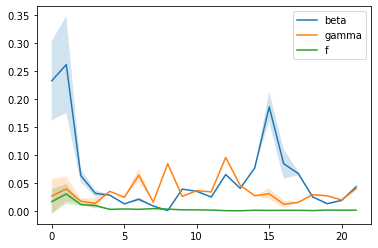

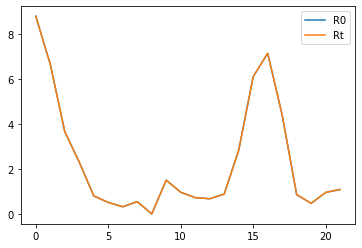

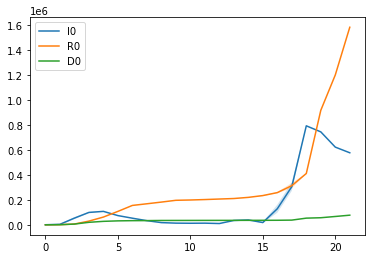

In [16]:
beta_err = np.array(variances["beta"]) ** 0.5
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.fill_between(range(0, len(means["beta"])), means["beta"] - beta_err, means["beta"] + beta_err, alpha=0.2)

gamma_err = np.array(variances["gamma"]) ** 0.5
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.fill_between(range(0, len(means["gamma"])), means["gamma"] - gamma_err, means["gamma"] + gamma_err, alpha=0.2)

f_err = np.array(variances["f"]) ** 0.5
plt.plot(range(0, len(means["f"])), means["f"])
plt.fill_between(range(0, len(means["f"])), means["f"] - f_err, means["f"] + f_err, alpha=0.2)

plt.legend(["beta", "gamma", "f"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.show()

# beta_err = np.array(variances["S0"]) ** 0.5
# plt.plot(range(0, len(means["S0"])), means["S0"])
# plt.fill_between(range(0, len(means["S0"])), means["S0"] - beta_err, means["S0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["I0"]) ** 0.5
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.fill_between(range(0, len(means["I0"])), means["I0"] - beta_err, means["I0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["R0"]) ** 0.5
plt.plot(range(0, len(means["R0"])), means["R0"])
plt.fill_between(range(0, len(means["R0"])), means["R0"] - beta_err, means["R0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["D0"]) ** 0.5
plt.plot(range(0, len(means["D0"])), means["D0"])
plt.fill_between(range(0, len(means["D0"])), means["D0"] - beta_err, means["D0"] + beta_err, alpha=0.2)


plt.legend(["I0", "R0", "D0"]) # (["S0", "I0", "R0", "D0"])

plt.show()

In [17]:
sird_meld = pd.DataFrame(means)
sird_meld = sird_meld.reset_index()
sird_meld = sird_meld.rename(columns={"index":"t"})
dates = (sird_meld["t"] * daywindow).to_list()
sird_meld["data"] = df["data"][dates].to_list()


print(sird_meld.head())

sird_meld.to_csv("sird_melding_weekly.csv")

sird_meld = pd.DataFrame(variances)
sird_meld = sird_meld.reset_index()
sird_meld = sird_meld.rename(columns={"index":"t"})
dates = (sird_meld["t"] * daywindow).to_list()
sird_meld["data"] = df["data"][dates].to_list()


print(sird_meld.head())

sird_meld.to_csv("sird_melding_weekly_variances.csv")

   t            S0             I0            R0            D0      beta  \
0  0  5.999972e+07     439.083143     -0.148456      8.061773  0.233052   
1  1  5.998918e+07    3819.191205    874.113979    642.256026  0.261837   
2  2  5.992694e+07   53353.991369   6107.879387   5745.458130  0.063299   
3  3  5.984859e+07   98939.358942  29545.556938  19858.872713  0.031343   
4  4  5.984271e+07  107368.600988  61850.458076  27590.406836  0.028251   

      gamma         f                data  
0  0.026562  0.016604 2020-02-24 18:00:00  
1  0.039434  0.030312 2020-03-10 18:00:00  
2  0.017316  0.011394 2020-03-25 17:00:00  
3  0.013600  0.009433 2020-04-09 17:00:00  
4  0.035037  0.002753 2020-04-24 17:00:00  
   t            S0            I0            R0            D0          beta  \
0  0  3.759758e+06  1.349638e+05  3.867319e+04  5.604034e+03  5.051600e-03   
1  1  8.664575e+07  1.936347e+07  2.626377e+06  2.501313e+06  7.508567e-03   
2  2  6.526872e+07  6.302769e+07  4.889158e+06  9.3

In [18]:
predictions = {}
in_keys = model.get_input_keys()
out_keys = model.get_output_keys()

for i in range(len(dataset) // daywindow):
    for k in range(len(in_keys)):
        model.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = model.eval_series(daywindow - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

RMS on S0: 50120.638658407595
RMS on I0: 46682.40573749123
RMS on R0: 44299.71189204042
Total RMSE: 141102.75628793924


### SEIRD with hidden E compartment

Like the SIRD case, melding fails (in an even more evident way). In order to rule out the ill-behaved time series of sigma (which the deterministic fitting failed to determine since no informations on E where available), an additional test with smoothed time series was performed (with no improvement on the outcome of melding).

In [9]:
dataset = pd.DataFrame()
dataset["t"] = df["t"]
dataset["i"] = df["totale_positivi"]
dataset["r"] = df["dimessi_guariti"]
dataset["d"] = df["deceduti"]
dataset["s"] = 60000000 - (dataset["i"] + dataset["r"])

dataset = dataset.set_index("t")

print(dataset.head())
dayinow=15

seird_df = pd.read_csv("hidden_seird_params_weekly.csv", parse_dates=["data"])
seird_df = seird_df.set_index("t")

print(seird_df.head())

     i   r   d         s
t                       
0  221   1   7  59999778
1  311   1  10  59999688
2  385   3  12  59999612
3  588  45  17  59999367
4  821  46  21  59999133
   Unnamed: 0            S0            E0            I0            R0  \
t                                                                       
0           0  5.999977e+07   3508.591880  3.255846e-09    245.720623   
1           1  5.998750e+07  35434.814715  5.929598e+03   1926.628351   
2           2  5.991954e+07  42861.600469  5.937620e+04   9105.787034   
3           3  5.985372e+07  42640.438065  9.846248e+04  27549.631600   
4           4  5.980538e+07  57998.229706  1.056757e+05  56743.215572   

             D0      beta         gamma     sigma             c             f  \
t                                                                               
0    118.333333  0.252366  2.448243e-07  0.121951  9.999621e-05  4.049382e-18   
1   1666.777586  0.159281  1.312522e-02  0.121951  1.000000e-04  9.401

Deterministic predictions for the hidden SEIRD model contain a lot of spurious oscillations, these give the melding a very low probability which underflows and causes divisions by zero.

To solve the problem, the dataset is smoothed, before feeding it to the Bayesian melding approach.

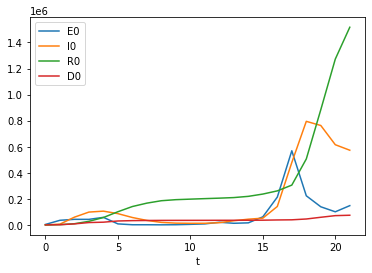

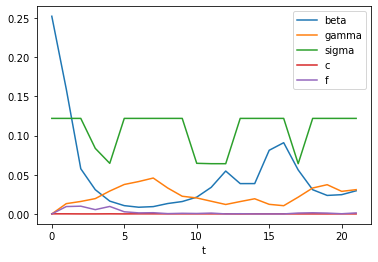

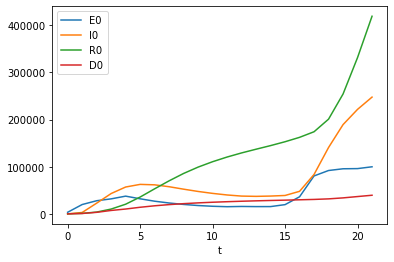

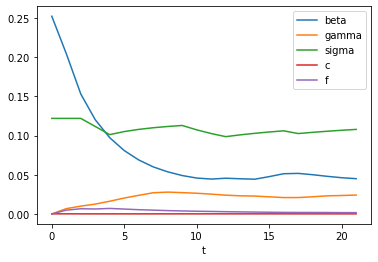

In [10]:
seird_df[["E0", "I0", "R0", "D0"]].plot()
seird_df[["beta", "gamma", "sigma", "c", "f"]].plot()

seird_df = seird_df.ewm(alpha=0.05).mean()

seird_df[["E0", "I0", "R0", "D0"]].plot()
seird_df[["beta", "gamma", "sigma", "c", "f"]].plot()

In [11]:
model = models.HiddenSEIRD()
daywindow=15
model_args = {"t": daywindow}
means = {}
variances = {}


s = Symbol("s", negative=False)
e = Symbol("e", negative=False)
i = Symbol("i", negative=False)
r = Symbol("r", negative=False)
d_symbol = Symbol("d", negative=False)
beta = Symbol("beta", negative=False)
gamma = Symbol("gamma", negative=False)
sigma = Symbol("sigma", negative=False)
f = Symbol("f", negative=False)
c = Symbol("c", negative=False)

for d in range(0, len(dataset) // daywindow):
    print("Melding window {}-{}...".format(d * daywindow, (d + 1) * daywindow))
    window_df = dataset[d * daywindow: (d + 1) * daywindow].reset_index()
    # Input priors and likelihoods:
        # Input priors and likelihoods:
    S_p = stats.Normal(s, window_df["s"].loc[0], window_df["s"].std())
    E_p = stats.Normal(e, seird_df["E0"].loc[d // daywindow], seird_df["E0"].std()) #Exposed are taken from the deterministic fit
    
    I_p = stats.Normal(i, window_df["i"].loc[0], window_df["i"].std())
    R_p = stats.Normal(r, window_df["r"].loc[0], window_df["r"].std())
    D_p = stats.Normal(d_symbol, window_df["d"].loc[0], window_df["d"].std())
    
    E_l = stats.Uniform(e, 0, 2 * seird_df["E0"].loc[d // daywindow])
    
#     S_l = stats.Normal(s, window_df["s"].loc[0], 1)
#     I_l = stats.Normal(i, window_df["i"].loc[0], 1)
#     R_l = stats.Normal(r, window_df["r"].loc[0], 1)

    Beta_p = stats.Normal(beta, seird_df["beta"].loc[d // daywindow], 0.3)
    Gamma_p = stats.Normal(gamma, seird_df["gamma"].loc[d // daywindow], 0.3)
    Sigma_p = stats.Normal(sigma, seird_df["sigma"].loc[d // daywindow], 0.5)
#    Sigma_p = stats.Normal(sigma, 0.09302, 0.014462) # Computed as the mean of 1/8.2 and 1/15.6 and considering the confidence interval as 95% (ie. these values lie inside x +- 2 sigma, so their sum is divided by 4 to get sigma)
   # Sigma_p = stats.Uniform(sigma, 0, 1)

    F_p = stats.Normal(f, seird_df["f"].loc[d // daywindow], 0.3)
    C_p = stats.Normal(c, seird_df["c"].loc[d // daywindow], 0.1)
    Beta_l = stats.Uniform(beta, 0, 1)
    Gamma_l = stats.Uniform(gamma, 0, 1)
    Sigma_l = stats.Uniform(sigma, 0, 1)
    F_l = stats.Uniform(f, 0, 1)
    C_l = stats.Uniform(c, 0, 1)

    # Output priors:
    S_out_p = stats.Normal(s, window_df["s"].mean(), window_df["s"].std())
    I_out_p = stats.Normal(i, window_df["i"].mean(), window_df["i"].std())
    R_out_p = stats.Normal(r, window_df["r"].mean(), window_df["r"].std())
    D_out_p = stats.Normal(d_symbol, window_df["d"].mean(), window_df["d"].std())

    #True observations:
    S_out_l = stats.Normal(s, window_df["s"].loc[len(window_df) - 1], window_df["s"].std())
    I_out_l = stats.Normal(i, window_df["i"].loc[len(window_df) - 1], window_df["i"].std())
    R_out_l = stats.Normal(r, window_df["r"].loc[len(window_df) - 1], window_df["r"].std())
    D_out_l = stats.Normal(d_symbol, window_df["d"].loc[len(window_df) - 1], window_df["d"].std())
    
    input_prior = melding.Joint_pdf({"S0": S_p, "E0": E_p, "I0": I_p, "R0": R_p, "D0": D_p, "beta": Beta_p, "gamma": Gamma_p, "sigma": Sigma_p, "f": F_p, "c": C_p})
    input_likelihood = melding.Joint_pdf({"S0": S_p, "E0": E_l, "I0": I_p, "R0": R_p, "D0": D_p, "beta": Beta_l, "gamma": Gamma_l, "sigma": Sigma_l, "f": F_l, "c": C_l})
    output_prior = melding.Joint_pdf({"S": S_out_p, "I": I_out_p, "R": R_out_p, "D": D_out_p})
    output_likelihood = melding.Joint_pdf({"S": S_out_l, "I": I_out_l, "R": R_out_l, "D": D_out_l})
    
    _, tmp_mean, tmp_var = melding.melding(model, model_args, input_prior, output_prior, input_likelihood, output_likelihood, 100000, 5000)
    for k, v in tmp_mean.items():
        if k not in means:
            means[k] = []
        means[k].append(v)
    for k, v in tmp_var.items():
        if k not in variances:
            variances[k] = []
        variances[k].append(v)

print(means)
print(variances)

Melding window 0-15...


C:\ProgramData\Anaconda3\lib\site-packages\sympy\stats\rv.py:1104: UserWarning: 
The return type of sample has been changed to return an iterator
object since version 1.7. For more information see
https://github.com/sympy/sympy/issues/19061
  warnings.warn(filldedent(message))


Melding window 15-30...
Melding window 30-45...
Melding window 45-60...
Melding window 60-75...
Melding window 75-90...
Melding window 90-105...
Melding window 105-120...
Melding window 120-135...
Melding window 135-150...
Melding window 150-165...


C:\gts\industry\SamsungATIV\melding.py:74: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)


Melding window 165-180...
Melding window 180-195...
Melding window 195-210...
Melding window 210-225...
Melding window 225-240...
Melding window 240-255...
Melding window 255-270...
Melding window 270-285...
Melding window 285-300...
Melding window 300-315...
Melding window 315-330...
{'S0': [59997701.45689399, 59980377.22707649, 59936199.7913774, 59879773.67058197, 59844283.35409692, 59809461.38095597, 59803872.86160092, 59797388.233020864, 59796102.10045388, 59792161.69235394, nan, 59786364.0704478, 59780308.34961928, 59766885.85796495, 59721957.7535902, 59737891.68787192, 59455211.59766728, 59302061.00103317, 58785119.47486812, 58431639.25674631, 58132314.642678395, 57989660.297901735], 'E0': [3846.9898356129697, 3247.5932148706715, 1906.8940867656672, 6187.637493914069, 5727.995759054677, 4616.465763062741, 6416.659401256765, 5124.426563327696, 4572.304351716295, 5199.243937393593, nan, 1283.3871553168522, 3782.9001378030302, 5398.822692697207, 5791.078255198346, 15210.984511882938

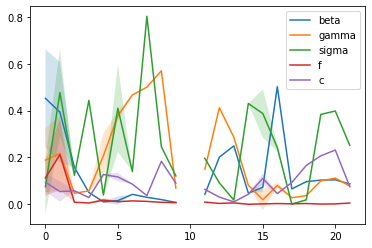

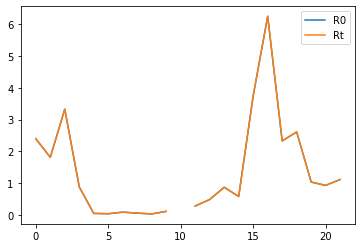

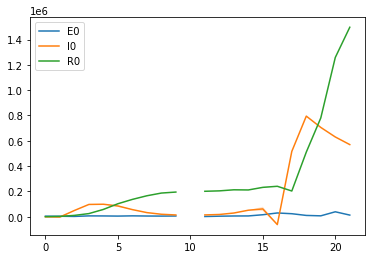

In [12]:
beta_err = np.array(variances["beta"]) ** 0.5
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.fill_between(range(0, len(means["beta"])), means["beta"] - beta_err, means["beta"] + beta_err, alpha=0.2)

gamma_err = np.array(variances["gamma"]) ** 0.5
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.fill_between(range(0, len(means["gamma"])), means["gamma"] - gamma_err, means["gamma"] + gamma_err, alpha=0.2)

sigma_err = np.array(variances["sigma"]) ** 0.5
plt.plot(range(0, len(means["sigma"])), means["sigma"])
plt.fill_between(range(0, len(means["sigma"])), means["sigma"] - sigma_err, means["sigma"] + sigma_err, alpha=0.2)

f_err = np.array(variances["f"]) ** 0.5
plt.plot(range(0, len(means["f"])), means["f"])
plt.fill_between(range(0, len(means["f"])), means["f"] - f_err, means["f"] + f_err, alpha=0.2)

c_err = np.array(variances["c"]) ** 0.5
plt.plot(range(0, len(means["c"])), means["c"])
plt.fill_between(range(0, len(means["c"])), means["c"] - c_err, means["c"] + c_err, alpha=0.2)

plt.legend(["beta", "gamma", "sigma", "f", "c"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.show()

# beta_err = np.array(variances["S0"]) ** 0.5
# plt.plot(range(0, len(means["S0"])), means["S0"])
# plt.fill_between(range(0, len(means["S0"])), means["S0"] - beta_err, means["S0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["E0"]) ** 0.5
plt.plot(range(0, len(means["E0"])), means["E0"])
plt.fill_between(range(0, len(means["E0"])), means["E0"] - beta_err, means["E0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["I0"]) ** 0.5
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.fill_between(range(0, len(means["I0"])), means["I0"] - beta_err, means["I0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["R0"]) ** 0.5
plt.plot(range(0, len(means["R0"])), means["R0"])
plt.fill_between(range(0, len(means["R0"])), means["R0"] - beta_err, means["R0"] + beta_err, alpha=0.2)


plt.legend(["E0", "I0", "R0"]) # (["S0", "E0", "I0", "R0"])

plt.show()

In [13]:
sir_meld = pd.DataFrame(means)
sir_meld = sir_meld.reset_index()
sir_meld = sir_meld.rename(columns={"index":"t"})
dates = (sir_meld["t"] * daywindow).to_list()
sir_meld["data"] = df["data"][dates].to_list()


print(sir_meld.head())

sir_meld.to_csv("hidden_seird_melding_weekly.csv")

sir_meld = pd.DataFrame(variances)
sir_meld = sir_meld.reset_index()
sir_meld = sir_meld.rename(columns={"index":"t"})
dates = (sir_meld["t"] * daywindow).to_list()
sir_meld["data"] = df["data"][dates].to_list()


print(sir_meld.head())

sir_meld.to_csv("hidden_seird_melding_weekly_variances.csv")

   t            S0           E0            I0            R0            D0  \
0  0  5.999770e+07  3846.989836  -1417.271390    -66.602905     -6.671180   
1  1  5.998038e+07  3247.593215  -2741.623856   2108.230948   1152.404804   
2  2  5.993620e+07  1906.894087  48915.867120  10107.013900   4469.126759   
3  3  5.987977e+07  6187.637494  96620.903311  24387.314725  21732.012414   
4  4  5.984428e+07  5727.995759  98250.204593  57253.322611  27081.556203   

       beta     gamma     sigma         f         c                data  
0  0.452262  0.188529  0.075185  0.112168  0.094354 2020-02-24 18:00:00  
1  0.393470  0.216857  0.476452  0.212524  0.054230 2020-03-10 18:00:00  
2  0.157670  0.047360  0.123540  0.008795  0.057620 2020-03-25 17:00:00  
3  0.050410  0.057122  0.443703  0.005605  0.028755 2020-04-09 17:00:00  
4  0.010489  0.206907  0.039849  0.018025  0.127100 2020-04-24 17:00:00  
   t            S0            E0            I0            R0            D0  \
0  0  1.733772e

In [14]:
predictions = {}
in_keys = model.get_input_keys()
out_keys = model.get_output_keys()

for i in range(len(dataset) // daywindow):
    for k in range(len(in_keys)):
        model.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = model.eval_series(daywindow - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["d"].iloc[:len(predictions["S"])].values, predictions["D"])
print("RMS on D0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

ZeroDivisionError: float division by zero